# [Part I] Pytorch 基礎教學

**[Note]**
執行時請先將執行階段改成 GPU 加速運算。

<small>更改方式: 執行階段> 變更執行階段類型> 硬體加速器選擇GPU> 儲存</small>
<hr>

**[Tips]**在一開始還不熟 function 時，查看官方的說明文件可以快速了解用法。

**Pytorch document:**

Layers:
- [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten)
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- [BatchNorm2d (optional)](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)
- [Dropout (optional)](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)


Activation function:
- [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid)
- [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
- [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)


## 1. Convolution

### 實際例子
```不必細看程式碼，只要關注在輸出結果就好。```

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

原始圖片:


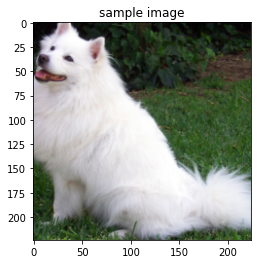

In [1]:
import torch
import torchvision
import time
torch.manual_seed(0)  # keep random seed
import urllib
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

model = torchvision.models.resnet18(pretrained=True)
model.eval()

url, filename = (
    "https://github.com/pytorch/hub/raw/master/images/dog.jpg",
    "dog.jpg",
)  # download image

urllib.request.urlretrieve(url, filename)

input_image = Image.open(filename)

preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model
print("原始圖片:")
plt.imshow(input_tensor.permute(1, 2, 0).cpu().detach().numpy())
plt.title("sample image")
plt.show()


[印出前 8 個 kernel 以及過完這個 kernel 的圖片]:



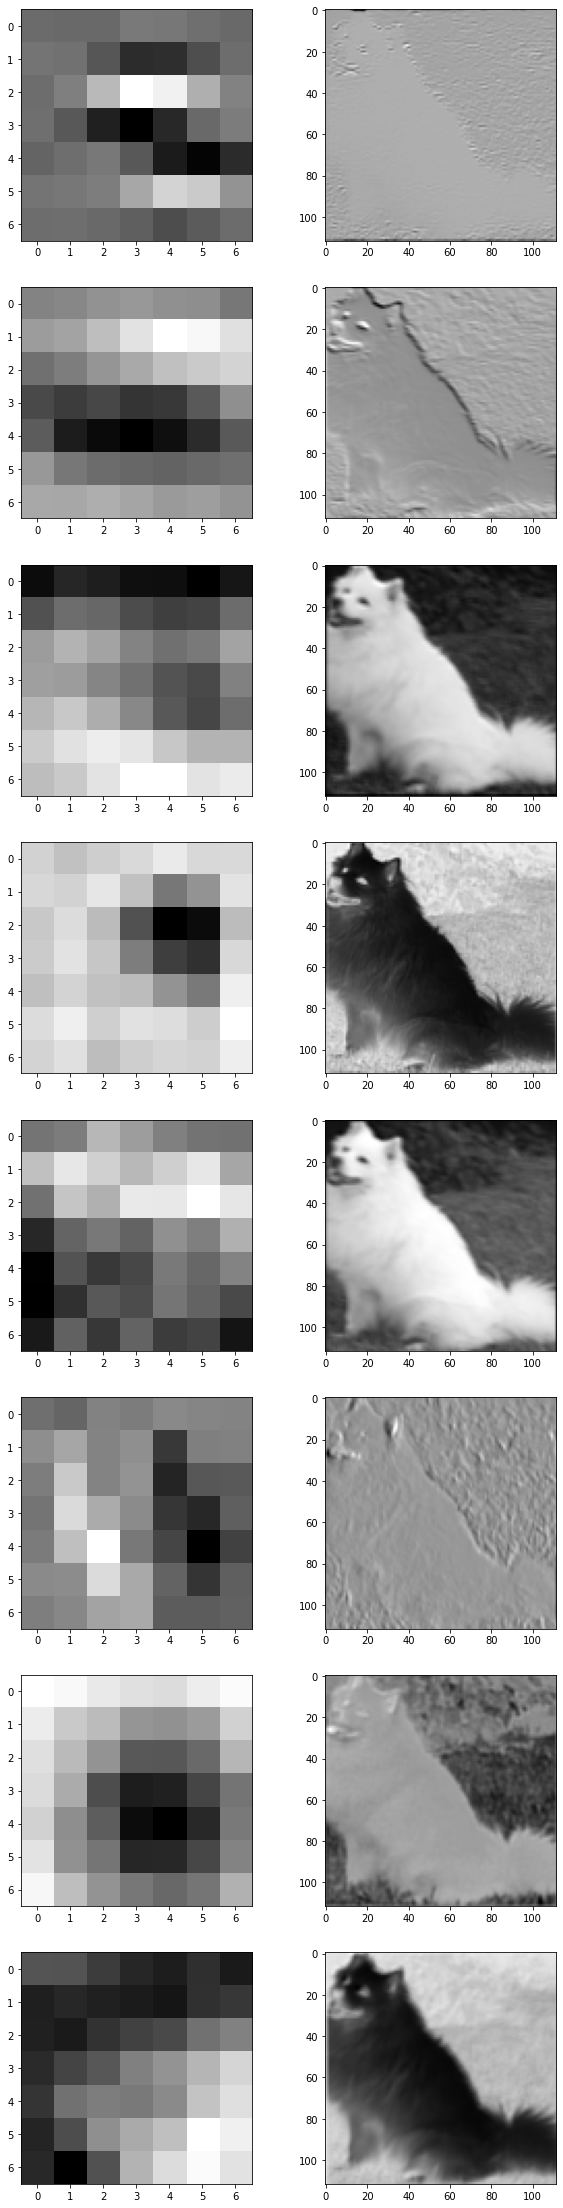

In [2]:
import matplotlib.pylab as plt  # plot module
import numpy as np


def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

conv_layer = model.conv1  # 從resnet 的 conv1 提取kernel，共有64個kernel

conv_images = conv_layer(input_batch)  # 把圖片丟入 conv_layer 中，得出卷積結果
kernel_images = (
    conv_layer.state_dict()["weight"].cpu().detach().numpy()
)  # 把 kernel 提取出來
print("\n[印出前 8 個 kernel 以及過完這個 kernel 的圖片]:\n")

fig = plt.figure(figsize=(10, 40))
columns = 2
rows = 8
for i in range(1, columns // 2 * rows + 1):
    kernel = rgb2gray(kernel_images[i - 1].transpose(1, 2, 0))
    img = conv_images[0][i - 1].cpu().detach().numpy()
    fig.add_subplot(rows, columns, 2 * i - 1)
    plt.imshow(kernel, cmap="gray")
    fig.add_subplot(rows, columns, 2 * i)
    plt.imshow(img, cmap="gray")

plt.show()

### 實作

創造卷積層

In [3]:
import torch
import torch.nn as nn

input = torch.rand(1, 1, 3, 3)  # 輸入矩陣 [batch,channel,w,h]
print("輸入:\n", input)
print()

conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2)  # 實體化卷積層
print("kernel and bias:\n", conv_layer.state_dict())

輸入:
 tensor([[[[0.8865, 0.2111, 0.7821],
          [0.7007, 0.1989, 0.5453],
          [0.2138, 0.9049, 0.0345]]]])

kernel and bias:
 OrderedDict([('weight', tensor([[[[-0.0430, -0.0678],
          [ 0.2051, -0.0561]]]])), ('bias', tensor([-0.0599]))])


輸出結果

In [4]:
output = conv_layer(input)
output

tensor([[[[ 0.0203, -0.1117],
          [-0.1103,  0.0782]]]], grad_fn=<ThnnConv2DBackward>)

## 2. Pooling

###實際例子

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



[印出前 8 個過完 convolution 以及再過完 max pooling 的圖片]:



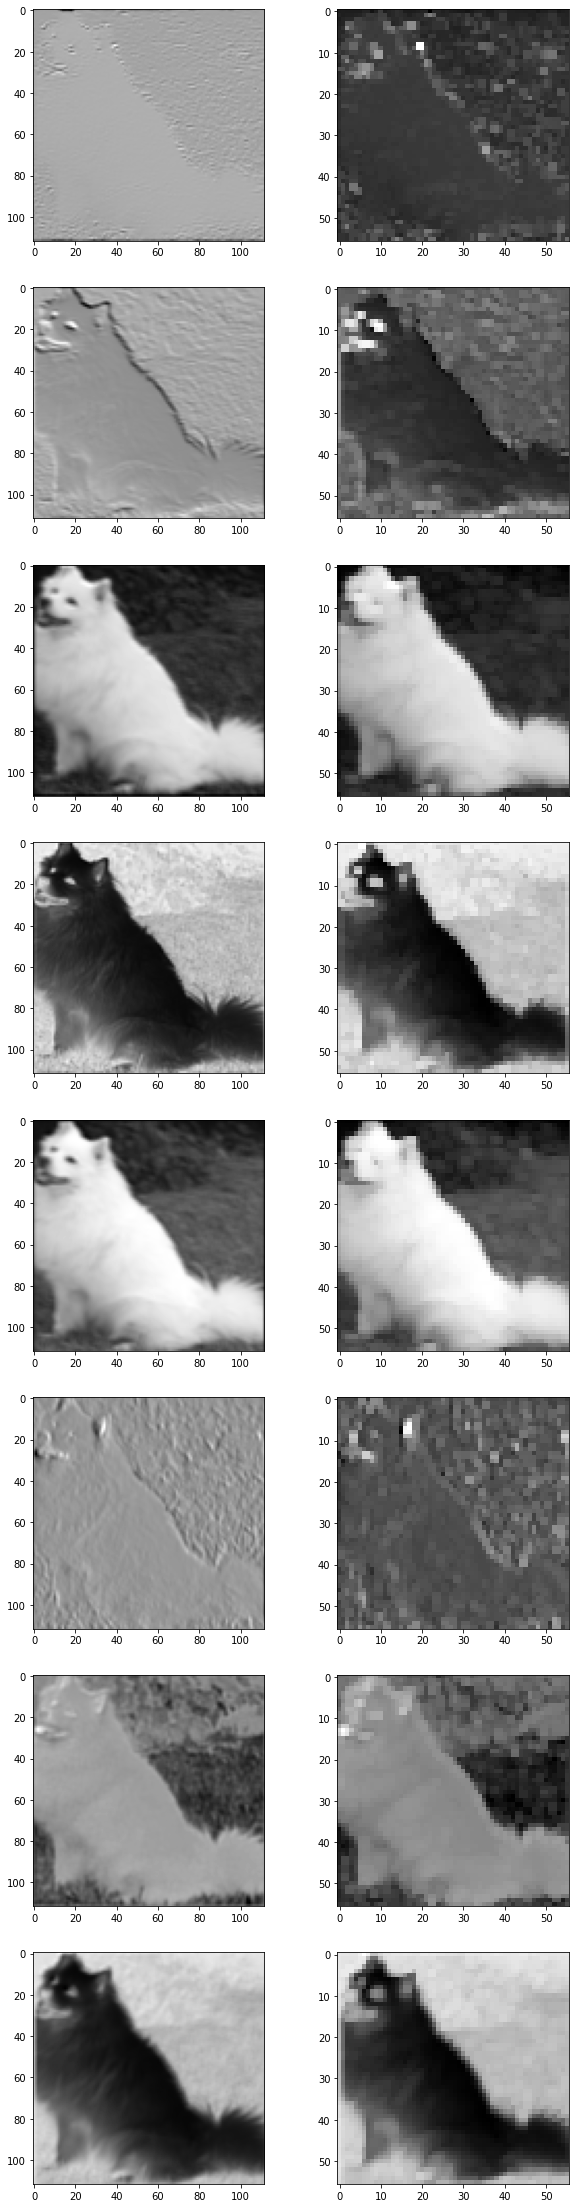

In [7]:
maxpool_layer = model.maxpool  # 提取 resnet 中的 maxpool 層
maxpool_images = maxpool_layer(conv_images)  # 將過完 convolution 後的圖片丟入 maxpool 層，得到結果
print("\n[印出前 8 個過完 convolution 以及再過完 max pooling 的圖片]:\n")

fig = plt.figure(figsize=(10, 40))
columns = 2
rows = 8
for i in range(1, columns // 2 * rows + 1):
    img = conv_images[0][i - 1].cpu().detach().numpy()
    maxpool_img = maxpool_images[0][i - 1].cpu().detach().numpy()
    fig.add_subplot(rows, columns, 2 * i - 1)
    plt.imshow(img, cmap="gray")
    fig.add_subplot(rows, columns, 2 * i)
    plt.imshow(maxpool_img, cmap="gray")

plt.show()

### 實作

宣告一個矩陣，代表圖片

In [8]:
image1 = torch.zeros(1, 1, 4, 4)
image1[0, 0, 0, :] = torch.tensor([1.0, 2.0, 3.0, -4.0])
image1[0, 0, 1, :] = torch.tensor([0.0, 2.0, -3.0, 0.0])
image1[0, 0, 2, :] = torch.tensor([0.0, 2.0, 3.0, 1.0])
image1

tensor([[[[ 1.,  2.,  3., -4.],
          [ 0.,  2., -3.,  0.],
          [ 0.,  2.,  3.,  1.],
          [ 0.,  0.,  0.,  0.]]]])

輸出結果

In [9]:
max1 = torch.nn.MaxPool2d(2)  # 實體化池化層
max1(image1)

tensor([[[[2., 3.],
          [2., 3.]]]])

<img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.1.3_max_pool_animation_2.gif" width = 500, align = "center">


## 3. Flatten

宣告輸入

In [10]:
image = torch.tensor([[[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
image

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

輸出結果

In [11]:
m = nn.Flatten()  # 實體化Flatten層
m(image)

tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

## 4. Fully connected layer

宣告輸入

In [12]:
input = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0]])
print("input:", input)

fc = nn.Linear(5, 2)  # 實體化全連接層

input: tensor([[1., 2., 3., 4., 5.]])


輸出結果

In [13]:
output = fc(input)  # input 5維、output 2維
output

tensor([[0.1207, 3.9209]], grad_fn=<AddmmBackward>)

## 5. Activation layer

同樣的 input 經過不同的 activation layer 後，得到不同的結果。

In [14]:
input = torch.tensor([[-5, -1, 0, 3, 8]]).float()
print("Input:", input)
print("-" * 50)

relu = nn.ReLU()  # 實體化ReLU層
out1 = relu(input)
print("ReLU:", out1)

tanh = nn.Tanh()  # 實體化Tanh層
out2 = tanh(input)
print("Tanh:", out2)

sigmoid = nn.Sigmoid()  # 實體化sigmoid層
out3 = sigmoid(input)
print("Sigmoid:", out3)

print("-" * 50)
softmax = nn.Softmax(dim=1)  # 實體化Softmax層(一般用在最後一層輸出)
out4 = softmax(input)
print("Softmax:", out4)

Input: tensor([[-5., -1.,  0.,  3.,  8.]])
--------------------------------------------------
ReLU: tensor([[0., 0., 0., 3., 8.]])
Tanh: tensor([[-0.9999, -0.7616,  0.0000,  0.9951,  1.0000]])
Sigmoid: tensor([[0.0067, 0.2689, 0.5000, 0.9526, 0.9997]])
--------------------------------------------------
Softmax: tensor([[2.2442e-06, 1.2253e-04, 3.3306e-04, 6.6898e-03, 9.9285e-01]])


# [Part II] LeNet-5 實作 

**LeNet-5 架構:**

<img src="https://camo.githubusercontent.com/2fb123b448a8af1dc812d523d94a2681ca2226da37512ff2d6fd8cfebb7ee871/687474703a2f2f75706c6f61642d696d616765732e6a69616e7368752e696f2f75706c6f61645f696d616765732f333632333732302d386262323833643032323835656438612e706e673f696d6167654d6f6772322f6175746f2d6f7269656e742f7374726970253743696d61676556696577322f322f772f31323430"/>

## 資料準備與前處理

引入所需 module

In [16]:
import torch  # pytorch
import torch.nn as nn  # 將 torch.nn 簡寫成 nn
import torchvision.transforms as transforms  # pytorch image processing module
import torchvision.datasets as dsets  # pytorch dataset
import matplotlib.pylab as plt  # plotting module
import numpy as np  # matrix module
import random
from tqdm.notebook import tqdm  # 顯示進度條

torch.manual_seed(0)  # keep random seed
random.seed(0)
np.random.seed(0)

定義用來檢視 MNIST 資料的function，之後可利用這個 function  查看 MNIST 圖片。

In [17]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
    plt.title("y = " + str(data_sample[1]))

將多個前處理結合在變數 composed 中:
1. resize()，將大小28x28的圖片轉成32*32
2. ToTensor()，把圖片轉成tensor(張量)才可以丟入model

參考資料: [transforms.Compose](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose)

In [18]:
IMAGE_SIZE = 32  # Original size: 28
composed = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ]
)

下載MNIST資料並將資料前處理

MNIST共包含了:
- 6萬張的Training data
- 1萬張的Testing data

參考資料: <a href='https://en.wikipedia.org/wiki/MNIST_database'>wiki-MNIST</a>

In [19]:
train_dataset = dsets.MNIST(
    root="./data", train=True, download=True, transform=composed
)
validation_dataset = dsets.MNIST(
    root="./data", train=False, download=True, transform=composed
)
print("Length of train_dataset:", len(train_dataset))
print("Length of validation_dataset:", len(validation_dataset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Length of train_dataset: 60000
Length of validation_dataset: 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


利用剛剛定義的 function 檢視圖片，可以試著把 num 改成其他數字。

**[Note]**原本是 28 x 28 的圖片，經過處理變成 32 x 32。

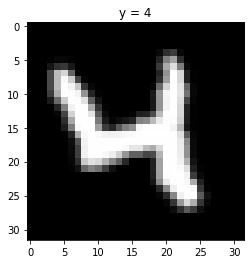

In [23]:
idx = 20  # <--- Any number you want
show_data(train_dataset[idx])

## **[Try yourself]** Defining model

選擇GPU進行訓練

In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is avalible.")
    print("Working on:", torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print("GPU is not avalible.")
    print("Working on CPU")

GPU is avalible.
Working on: Tesla K80


**[Try yourself]** 定義模型

<img src="https://camo.githubusercontent.com/2fb123b448a8af1dc812d523d94a2681ca2226da37512ff2d6fd8cfebb7ee871/687474703a2f2f75706c6f61642d696d616765732e6a69616e7368752e696f2f75706c6f61645f696d616765732f333632333732302d386262323833643032323835656438612e706e673f696d6167654d6f6772322f6175746f2d6f7269656e742f7374726970253743696d61676556696577322f322f772f31323430"/>

```
模型利用各種個 layer 一層一層堆疊，以達到想要的效果，過程類似像堆積木。

建立的過程需注意每層輸出的圖片大小(維度)
```

Formula: ```[(W−K+2P)/S]+1```

- W is the input volume - in this case 32
- K is the Kernel size - in this case 5
- P is the padding - in this case 0
- S is the stride - in this case 1

In LeNet-5:

C1: ```[(32 - 5 + 0)/1] + 1 = 28```

C3: ```[(14 - 5 + 0)/1] + 1 = 10```

<!-- model = nn.Sequential(
    # ===============START====================
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(5*5*16,120),
    nn.Tanh(),
    nn.Linear(120,84),
    nn.Tanh(),
    nn.Linear(84,10),
    # ===================END==================
)

model.to(device)  # moving to GPU -->

In [25]:
model = nn.Sequential(
    # ===============START====================
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(5*5*16,120),
    nn.Tanh(),
    nn.Linear(120,84),
    nn.Tanh(),
    nn.Linear(84,10),
    # ===================END==================
)

model.to(device)  # moving to GPU

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=400, out_features=120, bias=True)
  (6): Tanh()
  (7): Linear(in_features=120, out_features=84, bias=True)
  (8): Tanh()
  (9): Linear(in_features=84, out_features=10, bias=True)
)

檢視模型資訊

In [26]:
from torchsummary import summary

summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
              Tanh-7                  [-1, 120]               0
            Linear-8                   [-1, 84]          10,164
              Tanh-9                   [-1, 84]               0
           Linear-10                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.24
Estimated Tot

定義訓練函式，不必細看程式碼。

In [27]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs=4):
    N_train = len(train_dataset)  # train_set中的data數量
    N_test = len(validation_dataset)  # validation_set中的data數量
    train_acc = []  # store training accuracy
    cv_acc = []  # store validation accuracy
    train_loss = []  # store training loss
    cv_loss = []  # store validation loss

    for epoch in tqdm(range(n_epochs)):
        # ==================================training=============================================
        training_loss = []  # 每個 mini-batch 的 training loss
        correct = 0  # 累積每個 mini-batch 答對的數量
        model.train()  # switch model to train mode
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)  # 把 data 移到GPU中
            optimizer.zero_grad()  # 初始化梯度(gradient)
            z = model(x)  # 把x 丟入模型中得到預測值 z
            _, yhat = torch.max(z.data, 1)  # 找到z中最大值的位置 yhat
            correct += (yhat == y).sum().item()  # 計算 yhat 跟 y 相同的數量
            loss = criterion(z, y)  # 比較 prediction z 與 label y ，計算loss值
            loss.backward()  # 計算反向傳播(back-propogation)的梯度值
            optimizer.step()  # 更新參數
            training_loss.append(loss.item())  # 把每個 mini-batch 的loss值記錄下來
        train_loss.append(
            np.mean(training_loss)
        )  # training loss 是每個 mini-batch的loss值取平均
        train_acc.append(
            correct / N_train
        )  # accuracy 是把所有答對的數量 / 所有的data。 ACC = TP + FN / (TP+FP+TN+FN)

        # =================================validation===========================================
        training_loss = []
        correct = 0
        model.eval()  # switch model to train mode
        with torch.no_grad():
            for x_test, y_test in validation_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                z = model(x_test)
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()
                loss = criterion(z, y_test)
                training_loss.append(loss.item())
            cv_loss.append(np.mean(training_loss))
            cv_acc.append(correct / N_test)

    return train_acc, cv_acc, train_loss, cv_loss

定義超參數(hyper paeameters):
- loss function
- learning rate
- optimizer
- batch size

DataLoader 用來將資料丟入model，batch_size用來決定一次丟入多少個data進入model



In [28]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64)
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=1024
)

訓練模型

In [29]:
train_acc, cv_acc, train_loss, cv_loss = train_model(
    model=model,
    n_epochs=4,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=optimizer,
)

  0%|          | 0/4 [00:00<?, ?it/s]

## Learning curve

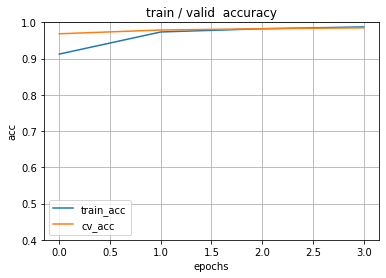

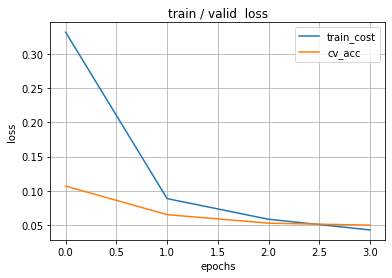

In [31]:
plt.plot(train_acc, label="train_acc")
plt.plot(cv_acc, label="cv_acc")
plt.title("train / valid  accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
axes = plt.gca()
axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss, label="train_cost")
plt.plot(cv_loss, label="cv_acc")
plt.title("train / valid  loss")
plt.xlabel("epochs")
plt.ylabel("loss")
# axes = plt.gca()
# axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [41]:
print("[Training] ACC: %2.2f"%train_acc[-1])
print("[Training] LOSS: %2.2f"%train_loss[-1])
print("-" * 10)
print("[Test] ACC: %2.2f"%cv_acc[-1])
print("[Test] LOSS: %2.2f"%cv_loss[-1])

[Training] ACC: 0.99
[Training] LOSS: 0.04
----------
[Test] ACC: 0.98
[Test] LOSS: 0.05


# [Part III] 建立自己的CNN模型

試著自己拚出一個 model，須注意每一層的輸出維度!<br>

**Formula:** ```[(W−K+2P)/S]+1```

- W is the input volume - in this case 32
- K is the Kernel size - in this case 5
- P is the padding - in this case 0
- S is the stride - in this case 1

<hr>

嘗試使用:
- nn.Conv2d()
- nn.AvgPool2d() / nn.MaxPool2d()
- nn.BatchNorm2d()
- nn.ReLU() / nn.Tanh() / nn.sigmoid()
- nn.Linear()
- nn.Flatten()

更多資訊請看官方說明 <a href="https://pytorch.org/docs/stable/nn.html">torch.nn</a>

**參考範例:**
```
my_model = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5),
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Dropout(p=0.5),
        nn.Linear(1176,10)
        )
```

**[Try yourself] 建立 model**

In [ ]:
# my_model = nn.Sequential(
#         #============================START================================
#         nn.Conv2d(#modify here),

#         #==============================END==============================
#         )

# my_model.to(device)

In [ ]:
from torchsummary import summary

summary(my_model, (1, 32, 32))

**[Try yourself] 定義超參數** 

試著更換:
- learning_rate
- optimizer
- batch_size

<a href="https://pytorch.org/docs/stable/optim.html">pytorch: optimizer</a>

**參考範例:**
```
learning_rate = 0.0005
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1024)
```

In [ ]:
# modify yourself
#============================START================================
learning_rate = #modify here
optimizer = #modify here
train_loader torch.utils.data.DataLoader(dataset=train_dataset, batch_size= #modify here )
#==============================END==============================

criterion = nn.CrossEntropyLoss()
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=1024
)

In [ ]:
train_acc, cv_acc, train_loss, cv_loss = train_model(
    model=my_model,
    n_epochs=4,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=optimizer,
)

### Learning curve

In [ ]:
plt.plot(train_acc, label="train_acc")
plt.plot(cv_acc, label="cv_acc")
plt.title("train / valid  accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
# axes = plt.gca()
# axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss, label="train_cost")
plt.plot(cv_loss, label="cv_acc")
plt.title("train / valid  loss")
plt.xlabel("epochs")
plt.ylabel("loss")
# axes = plt.gca()
# axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("[Training] ACC:", train_acc[-1])
print("[Training] LOSS:", train_loss[-1])
print("-" * 10)
print("[Test] ACC:", cv_acc[-1])
print("[Test] LOSS:", cv_loss[-1])

# [Optional] AlexNet

**AlexNet 架構:**
<hr>
<img src="https://miro.medium.com/max/3072/1*qyc21qM0oxWEuRaj-XJKcw.png" width="80%">

此部分在預處理時，有將先MNIST轉成RGB channel，並且對圖片做正規化處理，有興趣可以參考前處理的程式碼。


參考資料:
- [Pytorch|AlexNet](https://pytorch.org/hub/pytorch_vision_alexnet/)
- [原始論文](http://www.cs.toronto.edu/~hinton/absps/imagenet.pdf)

## 資料準備與前處理

In [ ]:
import torch  # pytorch

torch.manual_seed(0)  # keep random seed
import torch.nn as nn
import torchvision.transforms as transforms  # image processing module
import torchvision.datasets as dsets  # dataset
import matplotlib.pylab as plt  # plot module
import numpy as np  # matrix module
from tqdm.notebook import tqdm  # 顯示進度條

In [ ]:
def show_data(data_sample):
    image = data_sample[0].numpy().reshape(3, IMAGE_SIZE, IMAGE_SIZE)
    image = np.transpose(image, axes=[1, 2, 0])
    plt.imshow(image)
    plt.title("y = " + str(data_sample[1]))

In [ ]:
IMAGE_SIZE = 224  # Original size: 28

composed = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
train_dataset = dsets.MNIST(
    root="./data", train=True, download=True, transform=composed
)
validation_dataset = dsets.MNIST(
    root="./data", train=False, download=True, transform=composed
)

In [ ]:
print("Length of train_dataset:", len(train_dataset))
print("Length of validation_dataset:", len(validation_dataset))

檢視MNIST圖片

In [ ]:
num = 8  # <--- Any number you want
show_data(train_dataset[num])

## **[Try yourself]** Defining model

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is avalible.")
    print("Working on:", torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print("GPU is not avalible.")
    print("Working on CPU")

**[Try yourself] 定義model**

In [ ]:
class AlexNet(nn.Module):
    # Contructor
    def __init__(self):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            # ==================START========================
            # ===================END=========================
        )

    # Prediction
    def forward(self, x):
        x = self.feature(x)
        return x


model = AlexNet()

model.to(device)  # moving to GPU

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

In [ ]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs=4):
    N_test = len(validation_dataset)
    N_train = len(train_dataset)
    train_acc = []
    cv_acc = []
    train_loss = []
    cv_loss = []

    for epoch in tqdm(range(n_epochs)):
        # training=============================================
        training_loss = []
        correct = 0
        model.train()  # switch model to train mode
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
        train_loss.append(np.mean(training_loss))
        train_acc.append(correct / N_train)

        # validation===========================================
        training_loss = []
        correct = 0
        model.eval()  # switch model to train mode
        with torch.no_grad():
            for x_test, y_test in validation_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                z = model(x_test)
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()
                loss = criterion(z, y_test)
                training_loss.append(loss.item())
            cv_loss.append(np.mean(training_loss))
            cv_acc.append(correct / N_test)

    return train_acc, cv_acc, train_loss, cv_loss

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64)
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=256
)

In [ ]:
train_acc, cv_acc, train_loss, cv_loss = train_model(
    model=model,
    n_epochs=4,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=optimizer,
)

## Learning curve

In [ ]:
plt.plot(train_acc, label="train_acc")
plt.plot(cv_acc, label="cv_acc")
plt.title("train / valid  accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
# axes = plt.gca()
# axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss, label="train_cost")
plt.plot(cv_loss, label="cv_acc")
plt.title("train / valid  loss")
plt.xlabel("epochs")
plt.ylabel("loss")
# axes = plt.gca()
# axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("[Training] ACC:", train_acc[-1])
print("[Training] LOSS:", train_loss[-1])
print("-" * 10)
print("[Test] ACC:", cv_acc[-1])
print("[Test] LOSS:", cv_loss[-1])

# [Optional] VGG16

**VGG16(D欄位)架構:**
<hr>
<img src="https://neurohive.io/wp-content/uploads/2018/11/Capture-564x570.jpg" width="50%" >

**圖形化架構:**
<hr>
<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width="80%" >

此部分在預處理時，有將先MNIST轉成RGB channel，並且對圖片做正規化處理，有興趣可以參考前處理的程式碼。

參考資料:
- [Pytorch|vgg-nets](https://pytorch.org/hub/pytorch_vision_vgg/)
- [原始論文](https://arxiv.org/abs/1409.1556)


**[注意]** 訓練VGG-16需要花費一定時間，一個 epoch 約為 25 分鐘(batch_size=128)

## 資料準備與前處理

In [ ]:
import torch  # pytorch

torch.manual_seed(0)  # keep random seed
import torch.nn as nn
import torchvision.transforms as transforms  # image processing module
import torchvision.datasets as dsets  # dataset
import matplotlib.pylab as plt  # plot module
import numpy as np  # matrix module
from tqdm.notebook import tqdm  # 顯示進度條

In [ ]:
def show_data(data_sample):
    image = data_sample[0].numpy().reshape(3, IMAGE_SIZE, IMAGE_SIZE)
    image = np.transpose(image, axes=[1, 2, 0])
    plt.imshow(image)
    plt.title("y = " + str(data_sample[1]))

In [ ]:
IMAGE_SIZE = 224  # Original size: 28

composed = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
train_dataset = dsets.MNIST(
    root="./data", train=True, download=True, transform=composed
)
validation_dataset = dsets.MNIST(
    root="./data", train=False, download=True, transform=composed
)

In [ ]:
print("Length of train_dataset:", len(train_dataset))
print("Length of validation_dataset:", len(validation_dataset))

檢視MNIST圖片

In [ ]:
num = 8  # <--- Any number you want
show_data(train_dataset[num])

## **[Try yourself]** Defining model

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is avalible.")
    print("Working on:", torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print("GPU is not avalible.")
    print("Working on CPU")

**[Try yourself] 定義model**

In [ ]:
class VGG16(nn.Module):
    # Contructor
    def __init__(self):
        super(VGG16, self).__init__()

        self.feature = nn.Sequential(
            # =======================START=====================
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # try yourself
            # ========================END======================
        )

    # Prediction
    def forward(self, x):
        x = self.feature(x)
        return x


model = VGG16()

model.to(device)  # moving to GPU

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

In [ ]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs=4):
    N_test = len(validation_dataset)
    N_train = len(train_dataset)
    train_acc = []
    cv_acc = []
    train_loss = []
    cv_loss = []

    for epoch in tqdm(range(n_epochs)):
        # training=============================================
        training_loss = []
        correct = 0
        model.train()  # switch model to train mode
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
        train_loss.append(np.mean(training_loss))
        train_acc.append(correct / N_train)

        # validation===========================================
        training_loss = []
        correct = 0
        model.eval()  # switch model to train mode
        with torch.no_grad():
            for x_test, y_test in validation_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                z = model(x_test)
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()
                loss = criterion(z, y_test)
                training_loss.append(loss.item())
            cv_loss.append(np.mean(training_loss))
            cv_acc.append(correct / N_test)

    return train_acc, cv_acc, train_loss, cv_loss

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64)
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=256
)

[注意] 訓練VGG-16需要花費一定時間，一個 epoch 約為 25 分鐘(batch_size=128)

In [ ]:
train_acc, cv_acc, train_loss, cv_loss = train_model(
    model=model,
    n_epochs=4,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=optimizer,
)

## Learning curve

In [ ]:
plt.plot(train_acc, label="train_acc")
plt.plot(cv_acc, label="cv_acc")
plt.title("train / valid  accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
# axes = plt.gca()
# axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss, label="train_cost")
plt.plot(cv_loss, label="cv_acc")
plt.title("train / valid  loss")
plt.xlabel("epochs")
plt.ylabel("loss")
# axes = plt.gca()
# axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("[Training] ACC:", train_acc[-1])
print("[Training] LOSS:", train_loss[-1])
print("-" * 10)
print("[Test] ACC:", cv_acc[-1])
print("[Test] LOSS:", cv_loss[-1])

# 參考答案

## 1. LeNet-5

Method 1
```
model = nn.Sequential(
          nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5),
          nn.AvgPool2d(kernel_size=2),
          nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
          nn.AvgPool2d(kernel_size=2),
          nn.Flatten(),

          nn.Linear(5*5*16,120),
          nn.Tanh(),

          nn.Linear(120,84),
          nn.Tanh(),

          nn.Linear(84,10),
        )
model.to(device) # moving to GPU
```

Method2
```
class CNN(nn.Module):
    # Contructor
    def __init__(self, out_1=6, out_2=16):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    # Prediction
    def forward(self, x):
        x = self.avgpool(self.conv1(x))
        x = self.avgpool(self.conv2(x))
        x = self.flatten(x)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)

        return x

model = CNN(out_1=6, out_2=16)
model.to(device) # moving to GPU
```

## 2. AlexNet

```
class AlexNet(nn.Module):
    # Contructor
    def __init__(self,out):
        super(AlexNet, self).__init__()
        self.out = out
        self.feature = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=9216, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=self.out, bias=True)
        )
    # Prediction
    def forward(self, x):
        x = self.feature(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

model = AlexNet(10)

model.to(device) # moving to GPU
```

## 3. VGG16

```
class VGG16(nn.Module):
    # Contructor
    def __init__(self,out):
        super(VGG16, self).__init__()
        self.out = out
        self.feature = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=out, bias=True)
            )       
  
    def forward(self, x):
        x = self.feature(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

model = VGG16(10)

model.to(device) # moving to GPU
```